<a href="https://colab.research.google.com/github/TravisHunting/BinaryClassification/blob/master/DenseBinaryClassifier3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses a pre-trained model to determine whether or not you are a criminal or a celebrity. There is no in between, and the model is 100% accurate. In fact, this model actually *determines* reality. Use at your own risk. 

Run each of the code blocks in order and then at the end you will be able to upload your own images and find out whether you are destined for fame, or destined for prison.

I trained the original model on 150,000 images. 65k mugshots + 10k mugshots for validation, 65k celeb shots + 10k celeb shots for validation. 

To access the notebook with training steps interspersed with these steps, use this link: https://colab.research.google.com/drive/15Z2YNjsaSBl4_juuXSgp9DU0Epy3JLdT

Download the checkpoint file (this means you don't have to train the network yourself)

In [ ]:
!mkdir /tmp/save
#!pip install gdown
!gdown https://drive.google.com/uc?id=1YLxZsnUOEVBzKv66mou5PmtI_Td0NOn9   #download checkpoint

Unzip the checkpoint

In [ ]:
import os
import zipfile

local_zip = '/content/checkpoint.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/save')

zip_ref.close()

Import the various things you need to create the model.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Define the model.

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (100,100,3)), 
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

**Optional.** Display some info about the model.

In [ ]:
model.summary()

Compile the model.

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Load the checkpoint that was downloaded earlier

In [ ]:
model.load_weights('/tmp/save/my_checkpoint')  #If you have a saved TF checkpoint, load it here and skip training below

Import more stuff and download the haar cascade from github (used to recognize faces)

In [ ]:
from google.colab import files
from keras.preprocessing import image
import cv2
import requests
from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
 
face_grab = requests.get('https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml')
 
with open('haar_cascade.xml', 'wb') as f:
  f.write(face_grab.content)

Upload your own images and find out whether you and your friends look more like celebrities, or more like criminals. Run as many times as you like. After clicking "Run" scroll down a bit to use the "upload files" box. If no faces are detected, the image will be skipped. If faces are detected, each face will be pulled out and evaluated separately.

Saving 000153.jpg to 000153.jpg

Number of faces detected:  1

000153.jpg
 You are a beautiful celebrity.


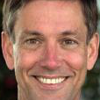

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/haar_cascade.xml')
 
uploaded = files.upload()
#print(uploaded.keys())
print()
 
for fn in uploaded.keys(): 
 
  path = '/content/' + fn
  path2 = '/content/uploads/'
  img = cv2.imread(path)
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) 
  #Lower scaleFactor for more detailed searching, Raise minNeighbors for more selective searching. 
  #Do the opposite for easier face detection (can cause false positives)
  image1 = Image.open(path)
 
  if len(faces) == 0:
    print(fn)
    print('No faces detected.')
    continue
 
  if len(faces) >= 1:
    print("Number of faces detected: ",len(faces))
    print()
    face_list = []
    
    for (x,y,w,h) in faces:
      image_res = image1.crop((x,y,x+w,y+h)) #crop the faces out of the image
      face_list.append(image_res.resize((100,100)))  #resize each image of a face to 100x100 square and collect into a list
    #print(type(image_res)) 
  
  for img in face_list:
    x = image.img_to_array(img)
    #plt.imshow(x/255.)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    #print("classification value: ",classes[0])
    if classes[0]<0.5:
      print(fn + "\n You are a filthy criminal.")
    else:
      print(fn + "\n You are a beautiful celebrity.")
    display(img)